# Multi-class Classification and Neural Networks

In [30]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io  # Used to load the OCTAVE *.mat files

import scipy.misc                # Used to show matrix as an image
import matplotlib.cm as cm       # Used to display images in a specific colormap
import random
from scipy.special import expit  # Vectorized sigmoid function

## Visualize the data

In [31]:
datafile = 'data/ex3data1.mat'
mat = scipy.io.loadmat(datafile)
X, y = mat['X'], mat['y']

# insert column of ones
X = np.insert(X, 0, 1, axis=1)

print("X dimensions:", X.shape)  # 5000 images with 400 pixels (20x20)
print("y dimensions:", y.shape)  # Labeled classification 1-10, 10 represents 0

X dimensions: (5000, 401)
y dimensions: (5000, 1)


(-0.5, 399.5, 19.5, -0.5)

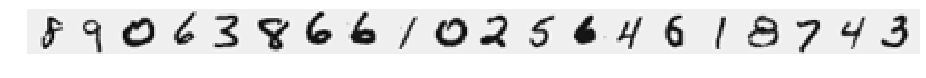

In [35]:
sample = np.random.choice(X.shape[0], 20)  # 20 row indices from X

fig, ax = plt.subplots(figsize=(16, 2))
ax.imshow(X[sample, 1:].reshape(-1,20).T, cmap='gray_r')  # 0 index is 1 constant
ax.axis('off')

## Multi-class Classification

#### Logistic regression hypothesis
#### $$ h_{\theta}(x) = g(\theta^{T}x)$$
#### $$ g(z)=\frac{1}{1+e^{−z}} $$

#### Regularized Cost Function 
#### $$ J(\theta) = \frac{1}{m}\sum_{i=1}^{m}\big[-y^{(i)}\, log\,( h_\theta\,(x^{(i)}))-(1-y^{(i)})\,log\,(1-h_\theta(x^{(i)}))\big] + \frac{\lambda}{2m}\sum_{j=1}^{n}\theta_{j}^{2}$$
#### Vectorized Cost Function
#### $$ J(\theta) = \frac{1}{m}\big((\,log\,(g(X\theta))^Ty+(\,log\,(1-g(X\theta))^T(1-y)\big) + \frac{\lambda}{2m}\sum_{j=1}^{n}\theta_{j}^{2}$$